In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import PIL as pil
import scipy as sc
import matplotlib.pyplot as plt
import re
onlyfiles = [f for f in listdir() if isfile(join(f)) and f[-4:] == ".csv"]
# print(onlyfiles)

# map((lambda filename: exec(filename[:-4] + " = pd.read_csv(filename)")), onlyfiles)
# for filename in onlyfiles:
#     exec(filename[:-4] + " = pd.read_csv(filename)")
#     print(filename[:-4] + "\n", eval(filename[:-4]).head(), "\n\n\n")

file_dict = {}
for filename in onlyfiles:
    df = pd.read_csv(filename)
    file_dict[filename[:-4]] = df#pd.read_csv(filename)")
print(file_dict)

{'building_map_dom_points':                                  FID  \
0          building_map_dom_points.1   
1          building_map_dom_points.2   
2          building_map_dom_points.3   
3          building_map_dom_points.4   
4          building_map_dom_points.5   
5          building_map_dom_points.6   
6          building_map_dom_points.7   
7          building_map_dom_points.8   
8          building_map_dom_points.9   
9         building_map_dom_points.10   
10        building_map_dom_points.11   
11        building_map_dom_points.12   
12        building_map_dom_points.13   
13        building_map_dom_points.14   
14        building_map_dom_points.15   
15        building_map_dom_points.16   
16        building_map_dom_points.17   
17        building_map_dom_points.18   
18        building_map_dom_points.19   
19        building_map_dom_points.20   
20        building_map_dom_points.21   
21        building_map_dom_points.22   
22        building_map_dom_points.23   
23        bu

In [7]:
def process_pnt(pnt):
    "takes single point str to list of 2 floats"
    return [float(i) for i in pnt[7:-1].split(" ")]

def process_poly(poly):
    "takes single poly str to list of 2 floats" 
    regex = re.compile(r'[(),]')
    return [float(k) for k in re.sub(regex, "", poly[16:-3]).split(" ")]

def process_geom(the_geom, as_matrix=False, sep_latlon = True, as_one = False):
    "Takes array/column, returns 2 column matrix of lon, lats or as seperate arrays"
    if the_geom[0][:5] == "POINT":
        j = [process_pnt(i) for i in the_geom]
        if as_matrix:
            return np.array(j)
        else:
            return [np.array(i) for i in zip(*j)]#list of lat/lon arrays
        
    else:#processing polygon or multilinestring, many pnts
        j = [process_poly(i) for i in the_geom]
        if as_one:#combines all lats/lons; converts polygon of multiple values to all 1 row/column
            j = np.ravel(j)[0]
            if as_matrix:
                return np.column_stack((np.array(j[::2]), np.array(j[1::2])))
            else:
                return [np.array(j[::2]), np.array(j[1::2])]
            
        else:#keeps poly rows seperate
            if as_matrix:#return list of matrixes
                return [np.column_stack((np.array(i[:-1:2]), np.array(i[1::2]))) for i in j]
            elif sep_latlon:#returns tuple of 2 lists of array of lats, and array of lons, grib
                list_of_arrs = [[np.array(i[::2]), np.array(i[1::2])] for i in j]
                return (list(arg) for arg in zip(*list_of_arrs))
            else:#return list of tuples of lat/lon arrays
                return [(np.array(i[:1:2]), np.array(i[1::2])) for i in j]


In [10]:
import itertools
#Seperates Lat/Lons of the Parish boundaries into list of arrays, dict w/ indexes
#seperate function?
# geoms = parish_bounds['the_geom'].groupby(parish_bounds["CENSUS_VAL"])
parish_bounds = file_dict['parishes3']
by_parish = parish_bounds.drop('FID', axis = 1).set_index(['CENSUS_VAL', 'OBJECTID'])

latlon_dict = dict()    
parish_latlon = []
i = iter(range(40))
for parish in by_parish.groupby('CENSUS_VAL'):#passed in as tuple of (censusval, df)
    (prevlat, prevlon) = process_geom(parish[1].reset_index()['the_geom'], sep_latlon = True)
    
    name = parish[1]['NAME'].unique()[0].replace("_", " ")
    if len(prevlat) > 1:#some GIS boundaries included irrelavent data, checked to ensure correct bounds
        if name != "St. Luke":
            j = list(map(len,prevlat))
            j = j.index(np.max(j))
            prevlat = prevlat[j]
            prevlon = prevlon[j]
        else:#St._Luke has 2 seperate sections
            pass
        if name == "?":#boundaries for all of Dominica, included corners
                (lat_min, lat_max), (lon_min, lon_max) = map((lambda x: (min(x), max(x))), [prevlat, prevlon])
                mask = [i>lat_min and i< lat_max and j>lon_min and  j<lon_max for i, j in zip(prevlat, prevlon)]#60x faster saving mins
                prevlat = prevlat[mask] 
                prevlon = prevlon[mask]
                name = "All Dominca"
    else:
        prevlat = prevlat[0]
        prevlon = prevlon[0]
    parish_latlon.append(prevlat)
    latlon_dict[name + 'lat'] = next(i)
    parish_latlon.append(prevlon)
    latlon_dict[name + 'lon'] = next(i)

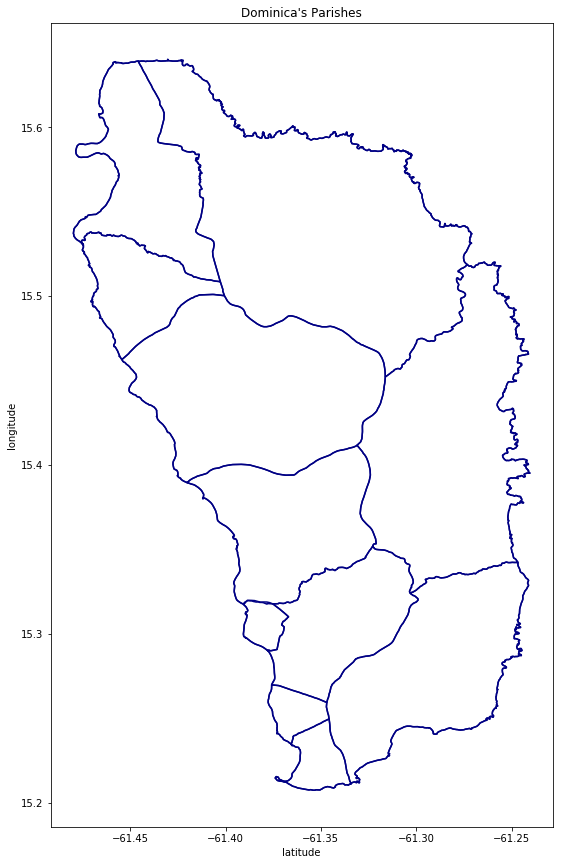

In [73]:
def set_defaults(keywords, defaults):#should do param validation here
    "assigns defaults to a given kwargv map input if var not def'd; check var def is a valid one"
    for key, val in defaults.items():
        if keywords.get(key, None) is None:
            keywords[key] = val
    return keywords


def process_plots(kwargv):#by = "as one", realative_loc = True, scale = 8, one_color = False):
    "standard preprocessesing for mapping, fig ax obj if as one, else list of fig/ax for each parish"
    if kwargv['by'] == "as one":#create 1 basic plot
        realative_loc = True
        fig = plt.figure(figsize = (kwargv['scale'], kwargv['scale'] * 46/28))#scale plot to lat/lon size (ignore earth's curvature)
        ax = plt.subplot(111)
        plt.title("Dominica's Parishes")
        plt.xlabel("latitude")
        plt.ylabel("longitude")
        figs = [fig]
        axs = [ax]
        
    elif kwargv['by'] == "sep parishes":#create list of plots of correct dims
        #not worth efficency of looping over 11 vars once vs. twice.
        figs = [0]*11#10 parishes + 1 overall map
        axs = [0]*11#no point in np.array, would have to resize in memory anyway
        names = iter(list(latlon_dict.keys()))
        for i in range(11):
            latname = next(names)
            lonname = next(names)
            if kwargv['realative_loc']:#Don't rescale for each parish
                xbnd = (-61.50, -61.22)#Dominica boundaries are -61.479, -61.240
                ybnd = (15.18, 15.66)#15,207, 15.640
            elif latname == "St. Lukelat":
                xbnd = (min(map(min, parish_latlon[latlon_dict["St. Lukelat"]])), max(map(max, parish_latlon[latlon_dict["St. Lukelat"]])))
                ybnd = (min(map(min, parish_latlon[latlon_dict["St. Lukelon"]])), max(map(max, parish_latlon[latlon_dict["St. Lukelon"]])))
            else:
                xbnd = (min(parish_latlon[latlon_dict[latname]]), max(parish_latlon[latlon_dict[latname]]))
                ybnd = (min(parish_latlon[latlon_dict[lonname]]), max(parish_latlon[latlon_dict[lonname]]))
            xsize = xbnd[1] - xbnd[0]
            ysize = ybnd[1] - ybnd[0]
            fig = plt.figure(figsize = ( kwargv['scale'],  kwargv['scale'] * ysize/xsize))
            ax = plt.subplot(111)
            ax.set_title(latname[:-3] + "'s Parish")
            ax.set_xlabel(latname.replace("lat", "'s latitude"))
            ax.set_ylabel(lonname.replace("lon", "'s longitude"))
            ax.set_xlim(xbnd)
            ax.set_ylim(ybnd)
            figs[i] = fig
            axs[i] = ax
    return figs, axs


def plot_map(**kwargv):#by = "sep parishes", realative_loc = True, scale = 8, one_color = False):
    "Draws a map of Dominica with Parishes, by = 'sep parishes' plots each parish individually returns as list "
    default = {'by': "as one", 'realative_loc': True, 'scale': 8, 'one_color': False}
    kwargv = set_defaults(kwargv, default)
    figs, axs = process_plots(kwargv)
    for i in range(11):#10 parishes plus 1 overall map
        fig = figs[i % len(figs)]#itertols.cycle() slower
        ax = axs[i % len(axs)]
        
        if kwargv['one_color']:
#             color = kwargv.get('color', None) or plt.com.jet([1])#Future: allow user to set single color/color cycle
            ax.set_prop_cycle(plt.cycler('color', plt.cm.jet([1])))

        if i == 6:#St. Luke is in 2 seperate sections; at index 12, i = 6
            p = ax.plot(parish_latlon[i * 2][0], parish_latlon[i * 2 + 1][0])#, color = "#1f77b4")
            ax.plot(parish_latlon[i * 2][1], parish_latlon[i * 2 + 1][1], color = p[0].get_color())
        else:
            ax.plot(parish_latlon[i * 2], parish_latlon[i*2 + 1],)# color = "#1f77b4")            

    if not kwargv['one_color']:
        ax.legend(list(map((lambda x: x[:-3]), list(latlon_dict.keys())[::2])))
        
    return fig, ax


fig, ax = plot_map(by = "as one", realative_loc = True, one_color = True, scale = 9)

#ax.scatter(*process_geom(dominica_points['the_geom']), )

In [12]:
#['building_map_dom_points.csv', 'dominica_points.csv', 'dominica_polygons.csv', 'd_towns_points.csv', 'parishes3.csv', 'roadsnew_lines.csv', 'wind_5c.csv']

#info on the files

#print(map((lambda i: print(i, eval(i[:-4]).columns)), onlyfiles))
copy_fig = fig
copy_ax = ax
#building map dom points is basically worthless, almost all "unknown"
#dominica has 1k labeld places by name, a highway field[most nans]
#dominica_polygons, Areas of interest, type of land covering(12 polys)
#d_towns_points, gives clustring of town Names as points, pops, Class [rural/suburband], 
#parish3, used
#roadsnew_lines, 3k roads w/ ROAD_TYPE ['Secondary_road' 'Tertiary_road' 'Primary_road']
#wind_5c 500 wind polys indicating strength
#worthless = [building_map_dom_points, dominica_points]
for file, df in file_dict.items():
    print(file, "\n")#, df.head())
    for i in df:
        print(i, df[i].unique()[:10], len(df[i].unique()), np.sum(df[i].isnull()), "\n")
    print("\n\n\n\n\n\n\n")
#     print(np.sum(building_map_dom_points.iloc[:,4] == 'Unknown'))
# process_geom(building_map_dom_points['the_geom'])

building_map_dom_points 

FID ['building_map_dom_points.1' 'building_map_dom_points.2'
 'building_map_dom_points.3' 'building_map_dom_points.4'
 'building_map_dom_points.5' 'building_map_dom_points.6'
 'building_map_dom_points.7' 'building_map_dom_points.8'
 'building_map_dom_points.9' 'building_map_dom_points.10'] 33468 0 

the_geom ['POINT (-61.43011564083071 15.421875629941708)'
 'POINT (-61.415741663633675 15.621303805854707)'
 'POINT (-61.41623219045045 15.621298045266414)'
 'POINT (-61.41604377818822 15.621287121983068)'
 'POINT (-61.41596610471708 15.621249262709014)'
 'POINT (-61.416010975281054 15.62118933464074)'
 'POINT (-61.41608525249057 15.621155440980475)'
 'POINT (-61.415842559139655 15.62127323697879)'
 'POINT (-61.41568160931454 15.621284508287781)'
 'POINT (-61.41564225347221 15.621268922171037)'] 33468 0 

LAYER ['Unknown Point Feature'] 1 0 

BUILDING_M ['B__1' 'B__2' 'B__3' 'B__4' 'B__5' 'B__6' 'B__7' 'B__8' 'B__9' 'B__10'] 33468 0 

BUILDING_U ['Unknown' 'church'

In [1059]:
type(wind_5c['ID'][0])
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet([10])))

NameError: name 'gca' is not defined

In [1067]:
clrs = [viridis(i* 250 //10) for i in wind_5c['ID']]#10 differenct catagories, #ax.set_prop_cycle(plt.cycler('color', plt.cm.jet([1])))
clrs

[(0.282623, 0.140926, 0.457517, 1.0),
 (0.255645, 0.260703, 0.528312, 1.0),
 (0.208623, 0.367752, 0.552675, 1.0),
 (0.166617, 0.463708, 0.558119, 1.0),
 (0.131172, 0.555899, 0.552459, 1.0),
 (0.128087, 0.647749, 0.523491, 1.0),
 (0.239374, 0.735588, 0.455688, 1.0),
 (0.440137, 0.811138, 0.340967, 1.0),
 (0.688944, 0.865448, 0.182725, 1.0),
 (0.945636, 0.899815, 0.112838, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0),
 (0.993248, 

In [17]:
def offset(parishsloc, windloc, lat = True):
    if lat:
        lat_max = list(map((lambda w: np.max([np.max(i) for i in w])), [parishsloc, windloc]))
        lat_offset = lat_max[0]  - lat_max[1]/100000
        lat_min = list(map((lambda w: np.min([np.min(i) for i in w])), [parishsloc, windloc]))
        lat_scale = (lat_min[0] - lat_min[1]/100000) / (lat_min[0] - lat_min[1]/100000)
        
lon_max = list(map((lambda w: np.max([np.max(i) for i in w])), [parishsloc, windloc]))
lon_offset = lon_max[0]  - lon_max[1]/100000
lon_min = list(map((lambda w: np.min([np.min(i) for i in w])), [parishsloc, windloc]))
lon_scale = (lon_min[0] - lon_min[1]/100000) / (lon_min[0] - lon_min[1]/100000)
return lon_offset, lon_scale


dict_keys(['building_map_dom_points', 'dominica_points', 'dominica_polygons', 'd_towns_points', 'parishes3', 'roadsnew_lines', 'wind_5c'])


-68.11896996905611 1.0000854271522632 -1.1681429461629378 1.0272268816427292


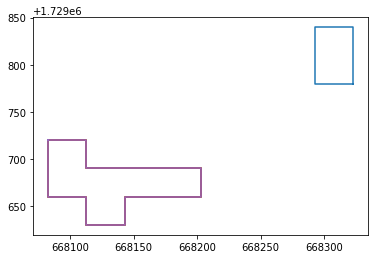

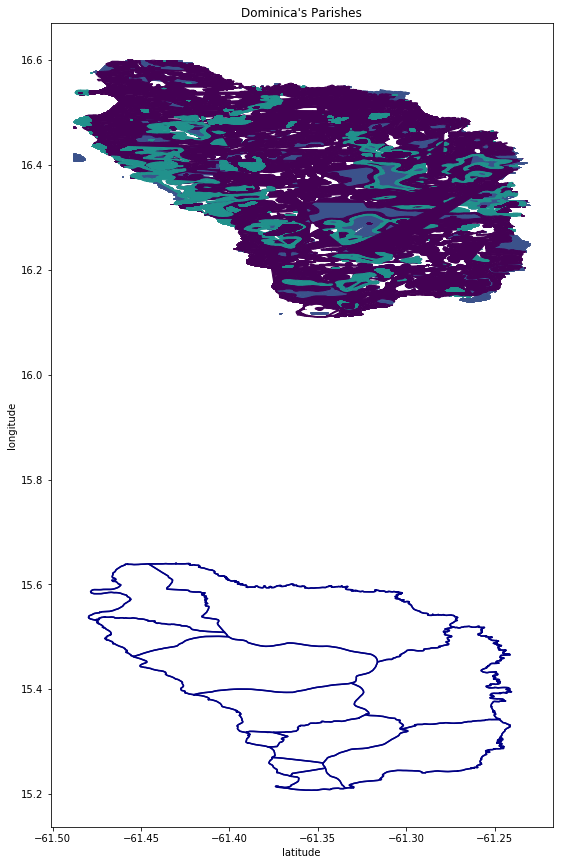

In [190]:
import matplotlib.colors as clr
import matplotlib.cm as cm

def offset(parishsloc, windloc, lat = True):
    if lat:
        lat_max = list(map((lambda w: np.max([np.max(i) for i in w])), [parishsloc, windloc]))
        lat_min = list(map((lambda w: np.min([np.min(i) for i in w])), [parishsloc, windloc]))
        lat_min_diff = lat_min[0]  - lat_min[1]/100000
        lat_max_diff = lat_max[0] - lat_max[1]/100000
        lat_scale =  lat_max_diff / lat_min_diff
        offset = (lat_min[0] - lat_min[1]/(100000 * lat_scale))
        return lat_max_diff, lat_scale
    else:
        lon_max = list(map((lambda w: np.max([np.max(i) for i in w])), [parishsloc, windloc]))
        lon_min = list(map((lambda w: np.min([np.min(i) for i in w])), [parishsloc, windloc]))
        lon_max_diff = lon_max[0]  - lon_max[1]/100000
        lon_min_diff = lon_min[0] - lon_min[1]/100000
        lon_scale = lon_max_diff/ lon_min_diff
        offset = (lon_min[0] - lon_min[1]/(100000 * lon_scale))#/lon_scale
        return offset, lon_scale

winds = file_dict['wind_5c']

jt = cm.get_cmap('viridis', 5)
colors = [jt((i - 1)/5) for i in winds['GRIDCODE']]#there are 5 wind levels
unique_clrs = [jt(i/5) for i in range(5)]#np.unique(colors, axis = 0)# this might be out of order
col_cnt = [(j, np.sum(list(map((lambda i: np.array_equal(unique_clrs[j], i)), colors)))) for j in  range(5)]#5 loops,bad
col_cnt.sort(key = (lambda x: x[1]), reverse = True)#plot largest area's first, add smaller areas on top
wind_order = {col_cnt[i][0]: i for i in range(5)}#key old to val ideal index
# print(col_cnt, wind_order)

windlat, windlon = process_geom(winds['the_geom'])
minlats = [0]*5
cnt = 0
indx = [0]*5
for i in range(len(windlat)):
    if np.min(windlat[i]) < minlats[cnt]:
        minlats[cnt] = np.min(windlat[i])
        indx[cnt] = i
        cnt += 1
        cnt %= 5
        
# plt.scatter(windlat[indx], windlon[indx])
cnt = 0
for i in indx:
#     plt.plot(windlat[i], windlon[i])
    del windlat[i - cnt]
    del windlon[i - cnt]
    cnt += 1

lat_offset, lat_scale = offset(parish_lats, windlat, lat = True)
lon_offset, lon_scale = offset(parish_lons, windlon, lat = False)
print(lat_offset, lat_scale, lon_offset, lon_scale)

windlat = [(wlat/100000*lat_scale + lat_offset) for wlat in windlat]
windlon = [(wlon/100000*lon_scale + lon_offset) for wlon  in windlon]

           
wind_poly = [(lats, lons, code, wind_order[code - 1]) for lats, lons, code in zip(windlat, windlon, winds['GRIDCODE'])]
wind_poly.sort(key = (lambda x: x[-1]))

fig, ax = plot_map(by = "as one", realative_loc = True, one_color = True, scale = 9)
for lats, lons, code, _ in wind_poly:
    ax.fill(lats, lons, c = colors[code - 1], alpha = 1)
fig.show()


TypeError: float() argument must be a string or a number, not 'module'

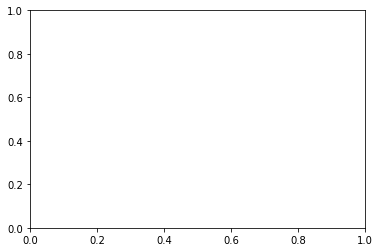

In [37]:
# next(iter(set(clrs)))



# cmap_jet =cm.get_cmap("jet")
# clrs = [cmap_jet(i) for i in wind_5c['ID']]#10 differenct catagories, #ax.set_prop_cycle(plt.cycler('color', plt.cm.jet([1])))
# plt.scatter(prevlat, prevlon, color = cmap_jet(wind_5c['ID']))

# cmap_jet(i) for i in wind_5c['ID']
# clr.from_levels_and_colors(wind_5c['ID'])

origin = 'lower'
CS = plt.contourf(lats, lons, clr, 10,
                  #[-1, -0.1, 0, 0.1],
                  #alpha=0.5,
                  cmap=cm.bone,
                  origin=origin)


In [1095]:
#[len(i[-4:].replace(")))","")) for i in wind_5c['the_geom']]#
#clr.normalize(vmin = 0,  vmax = 10)
[prevlat, prevlon] = process_geom(wind_5c['the_geom'], sep_latlon = True,)

# clrs = [jet(i * 25) for i in wind_5c['ID']]#10 differenct catagories, #ax.set_prop_cycle(plt.cycler('color', plt.cm.jet([1])))
#max 255 colors

#need better mapping
clr_set = iter(set(clrs))
# for i in range(10):
#     plt.scatter(i,i, color = next(clr_set))
# plt.show()
#clr.makeMappingArray(10, wind_5c['ID']/10)

normal = plt.Normalize(wind_5c['ID'].min(), wind_5c['ID'].max())
print(normal(wind_5c['ID']))
cmap = plt.cm.jet(normal(wind_5c['ID']))

for lats, lons, clr in zip(prevlat, prevlon, cmap):
    plt.fill(lat/10000, lon/100000, color = clr)#lon's don't match up w/ dominica
plt.show()

TypeError: float() argument must be a string or a number, not 'SingleBlockManager'

In [758]:
def plot_roads(copy_fig, copy_ax):

    [lats, lons] = process_geom(building_map_dom_points['the_geom'])    
    for col in building_map_dom_points.columns:
        ccopy_fig = copy_fig
        ccopy_ax = copy_ax
        ccopy_ax.plot(lats, lons, )
        

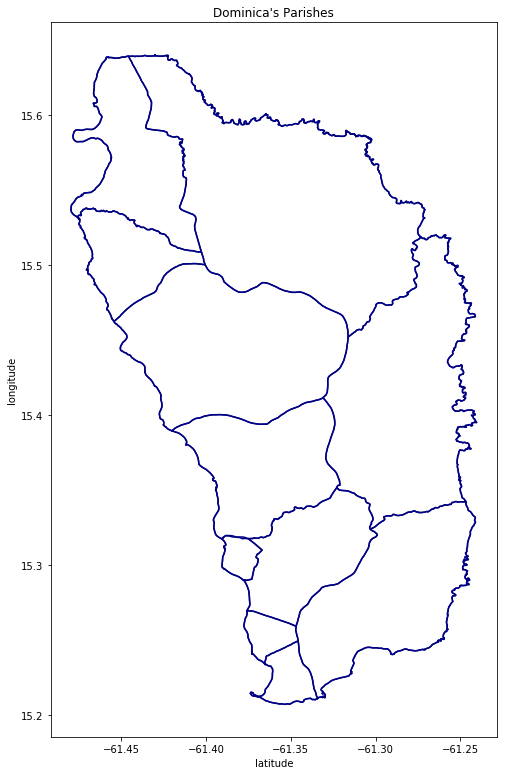

In [739]:
fig = plot_map(by = "as one", one_color = True)